In [1]:
# Cell 1: Imports 
import time
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing              import LabelEncoder
from sklearn.model_selection            import train_test_split, StratifiedKFold

from sklearn.ensemble                   import RandomForestClassifier
from sklearn.naive_bayes                import GaussianNB
from sklearn.metrics                    import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier


from tensorflow.keras.models            import Sequential
from tensorflow.keras.layers            import Dense, Dropout, LSTM, Embedding

from scipy.stats                        import friedmanchisquare, ttest_rel
from sklearn.feature_extraction.text    import TfidfVectorizer
from gensim.models                      import Word2Vec

import tensorflow as tf
import transformers.modeling_tf_utils as mfu
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification


c:\MestradoModelo\ModelTraining\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ler_arquivo_txt(path):
    return Path(path).read_text(encoding="utf-8").splitlines()

given = ler_arquivo_txt("../data/GivenSteps.txt")
when = ler_arquivo_txt("../data/WhenSteps.txt")
then = ler_arquivo_txt("../data/ThenSteps.txt")

steps  = given + when + then
labels = ["Precondição"]*len(given) + ["Ação"]*len(when) + ["Resultado"]*len(then)

df = pd.DataFrame({"step": steps, "label": labels})
df.head()

,step,label
0,the user is on the login page,Precondição
1,the user has entered a valid username,Precondição
2,the user has entered a valid password,Precondição
3,the user is logged in,Precondição
4,the user is on the homepage,Precondição


In [3]:
le = LabelEncoder()
df["y"] = le.fit_transform(df["label"])
tokenized = [s.split() for s in df["step"]]

w2v = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1, workers=4)
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df["step"]).toarray()

def get_features(X_tfidf, tok, w2v):
    feats = np.zeros((len(tok), X_tfidf.shape[1] + w2v.vector_size))
    for i, tks in enumerate(tok):
        vec = np.mean([w2v.wv[w] for w in tks if w in w2v.wv], axis=0)
        feats[i] = np.hstack((X_tfidf[i], vec))
    return feats

X = get_features(X_tfidf, tokenized, w2v)
y = df["y"].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=42)

In [5]:
# Multi Layer Perceptron (MLP)
def create_mlp_model(input_dim, num_classes):
    neurons = 143
    dropout_rate = 0.77
    activation = 'tanh'

    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons // 2, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model

# Long-short term memory (LSTM)
def create_lstm_model(input_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=64, input_length=input_dim))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    return model

# Random Forest
def create_rf_model(n_estimators=50, random_state=42):
    return RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

# Naive Bayes
def create_nb_model():
    return GaussianNB()

# XGBoost
def create_xgb_model():
    return XGBClassifier(
        # use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=4
    )


# ### BERT
# # 6.1 Prepara o tokenizer e o modelo
# le_tf      = LabelEncoder().fit(df["label"])
# labels_tf  = le_tf.transform(df["label"])
# tokenizer_ = AutoTokenizer.from_pretrained("bert-base-uncased")
# encodings  = tokenizer_(
#     df["step"].tolist(),
#     truncation=True, padding=True,
#     max_length=64, return_tensors="tf"
# )

# # 6.2 Monta tf.data.Dataset
# dataset_bert = tf.data.Dataset.from_tensor_slices((
#     dict(encodings),
#     labels_tf
# )).shuffle(len(df)).batch(16)

# # 6.3 Carrega e compila o modelo TF
# model_bert = TFAutoModelForSequenceClassification.from_pretrained(
#     "bert-base-uncased",
#     num_labels=len(le_tf.classes_)
# )
# model_bert.compile(
#     optimizer=tf.keras.optimizers.Adam(2e-5),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

# # Redireciona o keras dentro do transformers para o tf.keras
# mfu.keras = tf.keras
# mfu.keras.utils = tf.keras.utils

# # 6.4 Fine‑tuning
# model_bert.fit(dataset_bert, epochs=3)

In [6]:
def cross_validate_sklearn_metrics_with_time(create_fn, X, y, splits=5):
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    m = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
    for fold, (tr, te) in enumerate(kf.split(X, y), 1):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]
        print(f"RFOLD {fold} – train dist: {np.bincount(y_tr)}, test dist: {np.bincount(y_te)}")
        
        model = create_fn()
        start = time.time()
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        elapsed = time.time() - start
        
        m['accuracy'].append(accuracy_score(y_te, y_pred))
        m['precision'].append(precision_score(y_te, y_pred, average='macro', zero_division=0))
        m['recall'].append(   recall_score(y_te, y_pred, average='macro', zero_division=0))
        m['f1'].append(       f1_score(y_te,   y_pred, average='macro', zero_division=0))
        m['time'].append(elapsed)
    return {k: np.array(v) for k, v in m.items()}

# 2) Função de cross‑validation para modelos Keras
def cross_validate_keras_metrics_with_time(create_fn, X, y, epochs=5, batch_size=32, splits=5):
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    m = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
    for fold, (tr, te) in enumerate(kf.split(X, y), 1):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]
        print(f"KFOLD {fold} – train dist: {np.bincount(y_tr)}, test dist: {np.bincount(y_te)}")
        
        model = create_fn(X.shape[1], len(np.unique(y)))
        start = time.time()
        model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)
        _, acc = model.evaluate(X_te, y_te, verbose=0)
        y_prob = model.predict(X_te, verbose=0)
        y_pred = y_prob.argmax(axis=1)
        elapsed = time.time() - start
        
        m['accuracy'].append(acc)
        m['precision'].append(precision_score(y_te, y_pred, average='macro', zero_division=0))
        m['recall'].append(   recall_score(y_te, y_pred, average='macro', zero_division=0))
        m['f1'].append(       f1_score(y_te,   y_pred, average='macro', zero_division=0))
        m['time'].append(elapsed)
    return {k: np.array(v) for k, v in m.items()}

def cross_validate_transformer_tf(model_name: str, texts: list[str], labels: np.ndarray, label_encoder, splits: int = 5, epochs: int = 3, batch_size: int = 16, max_length: int = 64) -> dict[str, np.ndarray]:
    """
    Stratified K‑Fold CV para um Transformer em TensorFlow.
    Retorna dict com arrays de ['accuracy','precision','recall','f1','time'].
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    metrics = {k: [] for k in ['accuracy','precision','recall','f1','time']}

    for fold, (tr_idx, te_idx) in enumerate(kf.split(texts, labels), 1):
        # Divide textos e rótulos
        train_texts = [texts[i] for i in tr_idx]
        test_texts  = [texts[i] for i in te_idx]
        y_tr, y_te  = labels[tr_idx], labels[te_idx]
        print(f"TFOLD {fold} – train dist: {np.bincount(y_tr)}, test dist: {np.bincount(y_te)}")

        # Tokeniza e cria tf.data.Dataset
        enc_tr = tokenizer(train_texts, truncation=True, padding=True,
                           max_length=max_length, return_tensors="tf")
        enc_te = tokenizer(test_texts,  truncation=True, padding=True,
                           max_length=max_length, return_tensors="tf")
        ds_tr = tf.data.Dataset.from_tensor_slices((dict(enc_tr), y_tr))
        ds_te = tf.data.Dataset.from_tensor_slices((dict(enc_te), y_te))
        ds_tr = ds_tr.shuffle(len(train_texts)).batch(batch_size)
        ds_te = ds_te.batch(batch_size)

        # Instancia e compila um novo modelo para este fold
        model = TFAutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=len(label_encoder.classes_)
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(2e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        # Treino e predição
        start = time.time()
        model.fit(ds_tr, epochs=epochs, verbose=0)
        preds = model.predict(ds_te, verbose=0).logits
        elapsed = time.time() - start

        y_pred = np.argmax(preds, axis=1)

        # Armazena métricas
        metrics['accuracy'].append( accuracy_score(y_te, y_pred) )
        metrics['precision'].append( precision_score(y_te, y_pred, average='macro', zero_division=0) )
        metrics['recall'].append(    recall_score(y_te, y_pred, average='macro', zero_division=0) )
        metrics['f1'].append(        f1_score(y_te, y_pred, average='macro', zero_division=0) )
        metrics['time'].append(elapsed)

    # Converte listas em arrays numpy
    return {k: np.array(v) for k, v in metrics.items()}

In [7]:
metrics_mlp   = cross_validate_keras_metrics_with_time(create_mlp_model,  X, y, epochs=6, batch_size=44)
metrics_lstm  = cross_validate_keras_metrics_with_time(create_lstm_model, X, y, epochs=3, batch_size=32)
metrics_rf    = cross_validate_sklearn_metrics_with_time(create_rf_model,   X, y)
metrics_nb    = cross_validate_sklearn_metrics_with_time(create_nb_model,   X, y)
metrics_xgb = cross_validate_sklearn_metrics_with_time(create_xgb_model, X, y)

texts = df["step"].tolist()   # sua lista de sentenças
labels = df["y"].values       # array de 0,1,2 gerado pelo LabelEncoder

metrics_bert = cross_validate_transformer_tf(
    model_name="bert-base-uncased",
    texts=texts,
    labels=labels,
    label_encoder=le_tf,     # o LabelEncoder ajustado em df["label"]
    splits=5,
    epochs=2,
    batch_size=16,
    max_length=64
)

KFOLD 1 – train dist: [400 400 400], test dist: [100 100 100]
KFOLD 2 – train dist: [400 400 400], test dist: [100 100 100]
KFOLD 3 – train dist: [400 400 400], test dist: [100 100 100]
KFOLD 4 – train dist: [400 400 400], test dist: [100 100 100]
KFOLD 5 – train dist: [400 400 400], test dist: [100 100 100]
KFOLD 1 – train dist: [400 400 400], test dist: [100 100 100]
KFOLD 2 – train dist: [400 400 400], test dist: [100 100 100]
KFOLD 3 – train dist: [400 400 400], test dist: [100 100 100]
KFOLD 4 – train dist: [400 400 400], test dist: [100 100 100]
KFOLD 5 – train dist: [400 400 400], test dist: [100 100 100]
RFOLD 1 – train dist: [400 400 400], test dist: [100 100 100]
RFOLD 2 – train dist: [400 400 400], test dist: [100 100 100]
RFOLD 3 – train dist: [400 400 400], test dist: [100 100 100]
RFOLD 4 – train dist: [400 400 400], test dist: [100 100 100]
RFOLD 5 – train dist: [400 400 400], test dist: [100 100 100]
RFOLD 1 – train dist: [400 400 400], test dist: [100 100 100]
RFOLD 2 

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TFOLD 2 – train dist: [400 400 400], test dist: [100 100 100]


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TFOLD 3 – train dist: [400 400 400], test dist: [100 100 100]


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TFOLD 4 – train dist: [400 400 400], test dist: [100 100 100]


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TFOLD 5 – train dist: [400 400 400], test dist: [100 100 100]


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


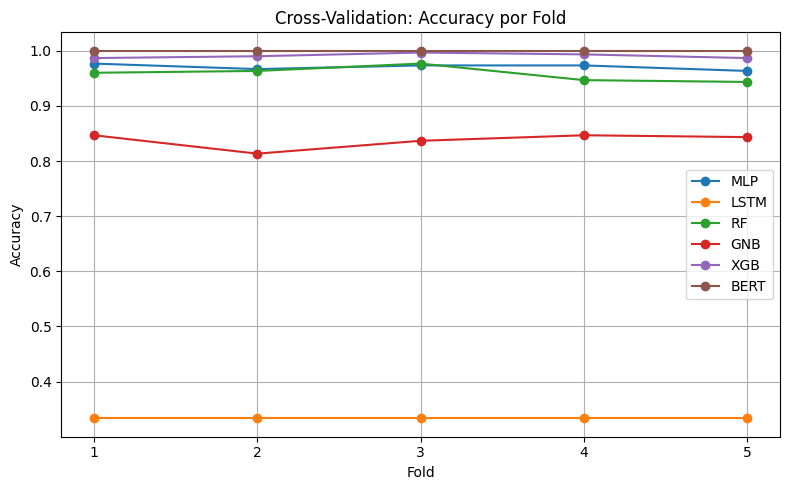

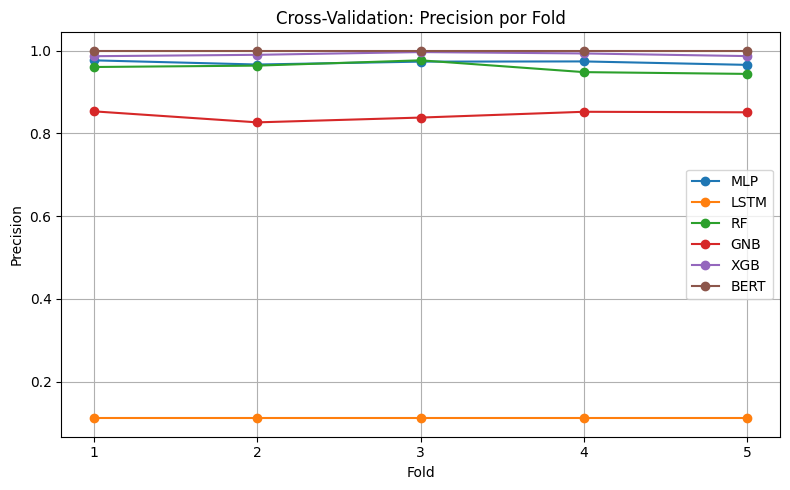

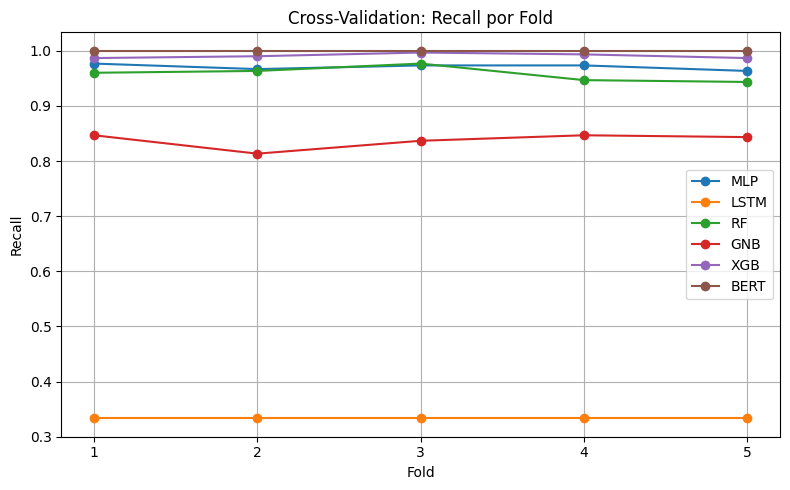

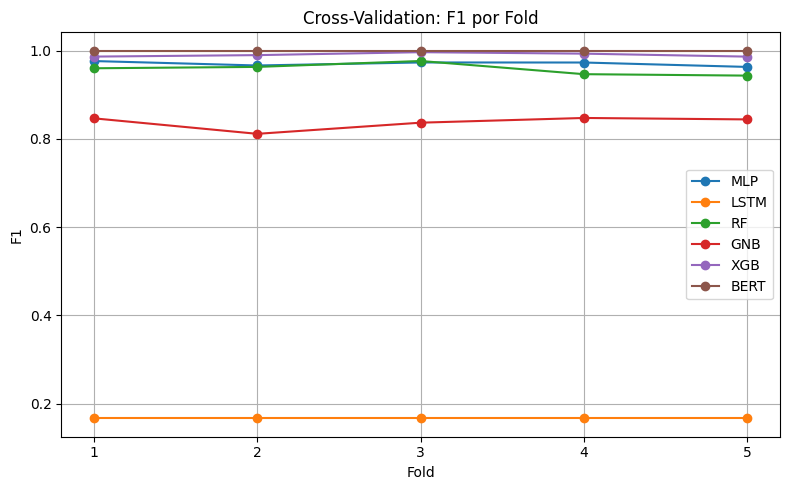

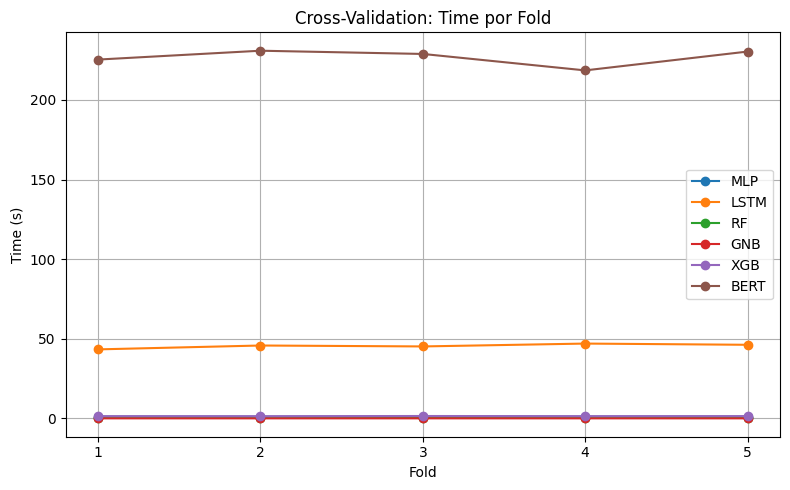

In [8]:
model_names  = ['MLP', 'LSTM', 'RF', 'GNB', 'XGB', 'BERT']
metrics_objs = [metrics_mlp, metrics_lstm, metrics_rf, metrics_nb, metrics_xgb, metrics_bert]
metric_keys  = ['accuracy', 'precision', 'recall', 'f1', 'time']
# Dicionário: para cada métrica, um sub-dict modelo→array de folds
cv_metrics = {
    mk: {name: mo[mk] for name, mo in zip(model_names, metrics_objs)}
    for mk in metric_keys
}

# 2) Função genérica para plotar uma métrica por fold
def plot_cv_metric(cv_dict, metric_name, ylabel=None):
    folds = np.arange(1, len(next(iter(cv_dict.values()))) + 1)
    plt.figure(figsize=(8, 5))
    for model, values in cv_dict.items():
        plt.plot(folds, values, marker='o', label=model)
    plt.xlabel('Fold')
    plt.ylabel(ylabel or metric_name.capitalize())
    plt.title(f'Cross-Validation: {metric_name.capitalize()} por Fold')
    plt.xticks(folds)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3) Gera um gráfico para cada métrica
for mk in metric_keys:
    ylabel = 'Time (s)' if mk == 'time' else mk.capitalize()
    plot_cv_metric(cv_metrics[mk], mk, ylabel=ylabel)

In [10]:
# Monta as linhas
rows = []
for name, m in zip(model_names, metrics_objs):
    rows.append([
        name,
        m['accuracy'].mean(),  m['accuracy'].std(),
        m['precision'].mean(), m['precision'].std(),
        m['recall'].mean(),    m['recall'].std(),
        m['f1'].mean(),        m['f1'].std(),
        m['time'].mean(),      m['time'].std()
    ])

# Cabeçalhos
columns = [
    'model',
    'acc_mean', 'acc_std',
    'prec_mean', 'prec_std',
    'recall_mean', 'recall_std',
    'f1_mean', 'f1_std',
    'time_mean', 'time_std'
]

# DataFrame e impressão
summary_df = pd.DataFrame(rows, columns=columns)
print(summary_df.to_string(index=False))

model  acc_mean  acc_std  prec_mean     prec_std  recall_mean  recall_std  f1_mean   f1_std  time_mean  time_std
  MLP  0.970667 0.004899   0.971359 4.358040e-03     0.970667    0.004899 0.970594 0.004913   1.085150  0.024310
 LSTM  0.333333 0.000000   0.111111 1.387779e-17     0.333333    0.000000 0.166667 0.000000  45.495201  1.230490
   RF  0.958000 0.012037   0.958702 1.171014e-02     0.958000    0.012037 0.958116 0.011967   0.327481  0.023918
  GNB  0.837333 0.012543   0.844391 1.035858e-02     0.837333    0.012543 0.837400 0.013440   0.015929  0.001782
  XGB  0.990667 0.003887   0.990778 3.819247e-03     0.990667    0.003887 0.990659 0.003895   1.406355  0.041571
 BERT  1.000000 0.000000   1.000000 0.000000e+00     1.000000    0.000000 1.000000 0.000000 226.849909  4.564256
